This notebook explores the Gujarat broiler and layer farm dataset from Marie-Cecile Dupas. It follows the same basic steps as exploreChileData.ipynb, except that we examine all of Gujarat at the same time instead of looking at a subset of sub-regions.

Dupas et al. (2024) mention that 59% of the farms are associated with village centroids, rather than actual farms. I can see in the data, both in the building scatter plots and by mapping farm coords, that most sets of coordinates are not close to farm buildings. That means that this dataset is of limited use for characterising farm buildings as a function of animal numbers, as I did for Chile. However, it will probably be feasible to manually select some large farms to be included in the general training dataset and/or for use as a held-out test set.

In [19]:
#!pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import geopandas as gpd
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

In [3]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
gdf1 = gpd.read_file('/content/drive/MyDrive/CAFO_data/India/Gujarat_broilers.shp').to_crs("EPSG:4326")
gdf2 = gpd.read_file('/content/drive/MyDrive/CAFO_data/India/Gujarat_layers.shp').to_crs("EPSG:4326")

In [5]:
display(gdf1.head(2))
display(gdf2.head(2))

,Stock,geometry
0,15000.0,POINT (73.92916 23.14182)
1,10000.0,POINT (73.35584 23.19060)


,Stock,geometry
0,30000.0,POINT (72.66649 22.89294)
1,89000.0,POINT (72.37716 22.93431)


In [6]:
broiler_range = (5000, 1e7)
layer_range = (5000, 1e7)

In [7]:
explore.describe_data(gdf1, 'broilers', broiler_range, 'geometry', 'Stock')
explore.describe_data(gdf2, 'layers', layer_range, 'geometry', 'Stock')

There are 2611 entries in the broilers spreadsheet
2611 farms have valid coordinates
0 farms report 0 broilers
The largest farm reports 90000.0 broilers
There are 1107 farms with 0 < broilers < 5000
  - They account for 3320720.0 broilers
There are 1101 farms with  5000 < broilers < 10000000.0
  - They account for 11808953.0 broilers 

There are 311 entries in the layers spreadsheet
311 farms have valid coordinates
0 farms report 0 layers
The largest farm reports 300000.0 layers
There are 31 farms with 0 < layers < 5000
  - They account for 94940.0 layers
There are 265 farms with  5000 < layers < 10000000.0
  - They account for 8241054.0 layers 



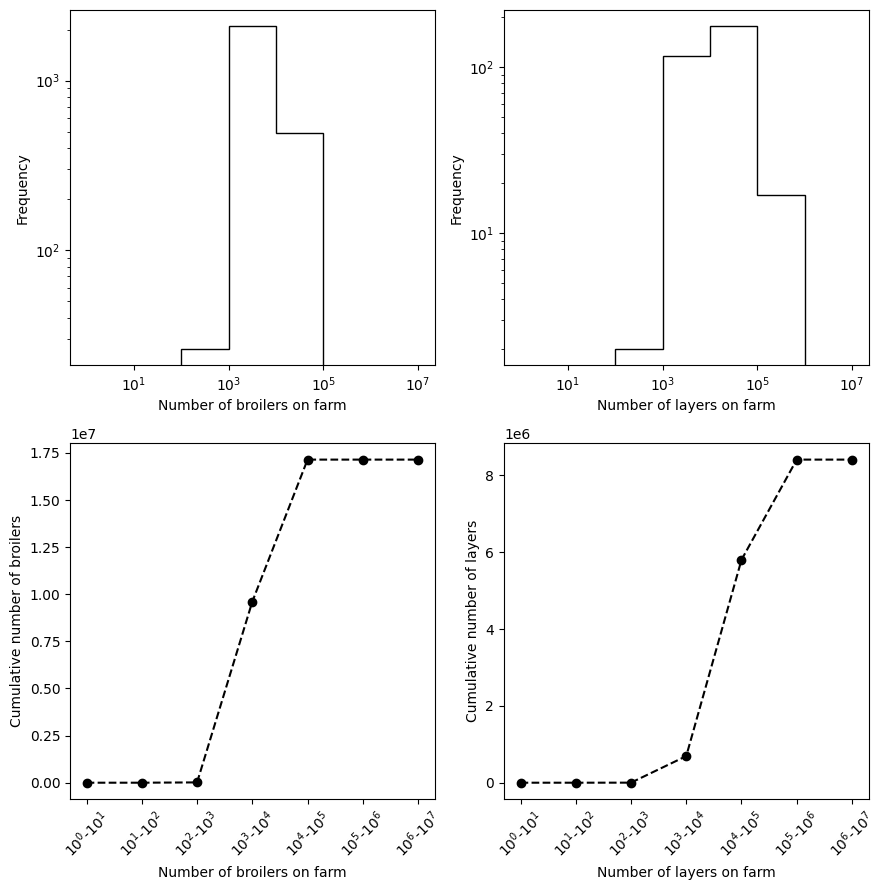

In [8]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))

explore.histo(gdf1, ax1, ax3, 'broilers', 'Stock')
explore.histo(gdf2, ax2, ax4, 'layers', 'Stock')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/CAFO_data/Analysis/Gujarat_histograms.png')

In [9]:
def refine(gdf, size_range):
  gdf = gdf[(gdf['Stock'] > size_range[0]) & (gdf['Stock'] < size_range[1])]
  fc = geemap.geopandas_to_ee(gdf[["geometry"]])

  return gdf, fc

broilers, broilers_fc = refine(gdf1, broiler_range)
layers, layers_fc = refine(gdf2, layer_range)

In [20]:
gujarat = gpd.read_file('/content/drive/MyDrive/CAFO_data/India/Gujarat_border.shp')
gujarat_geom = geemap.geopandas_to_ee(gujarat[['geometry']])

In [11]:
min_building_size = 500

buildings = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/IND")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
      .filterBounds(gujarat_geom)
)

In [12]:
Map = geemap.Map()
Map.centerObject(broilers_fc.first().geometry(), 10)

os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

region_viz = {'color':'red', 'fillColor':'00000000'}
building_viz = {'color':'orange', 'fillColor':'00000000'}

Map.add_basemap("HYBRID")
#Map.addLayer(buildings.style(**building_viz), {}, "")
Map.addLayer(broilers_fc, {'color':'pink', 'width':6}, "Broiler farms")
Map.addLayer(layers_fc, {'color':'cyan', 'width':6}, "Layer farms")


Map

In [21]:
#utils.write_to_file(buildings, f"Gujarat_{min_building_size}m2", 'India')
#utils.ee_task_status()

In [22]:
gdf = gpd.read_file(f"/content/drive/MyDrive/CAFO_data/India/Gujarat_{min_building_size}m2.geojson")
print(f"There are {len(gdf)} buildings > {min_building_size} sq m")

There are 233228 buildings > 500 sq m


In [15]:
# Buffer the farm gdf geometry and do a spatial join with the buildings gdf
# to identify buildings above <min_building_size> within <dist> m

dist = 200

#gdf['buildings_geom'] = gdf['geometry']
#
#def join_farms_and_buildings(farms, dist):
#
#  farms = farms.to_crs("EPSG:32643")
#  farms['geometry'] = farms['geometry'].buffer(dist)
#  farms = farms.to_crs("EPSG:4326")
#
#  joined = farms.sjoin(gdf, how='inner', predicate='intersects')
#  joined['index_right'] = joined['index_right'].astype(int)
#
#  return joined

broiler_buildings = explore.join_farms_and_buildings(broilers, gdf, dist)
layer_buildings = explore.join_farms_and_buildings(layers, gdf, dist)

In [16]:
broiler_bldgs_2 = explore.get_dimensions(broiler_buildings, crs="EPSG:32643")
layer_bldgs_2 = explore.get_dimensions(layer_buildings, crs="EPSG:32643")

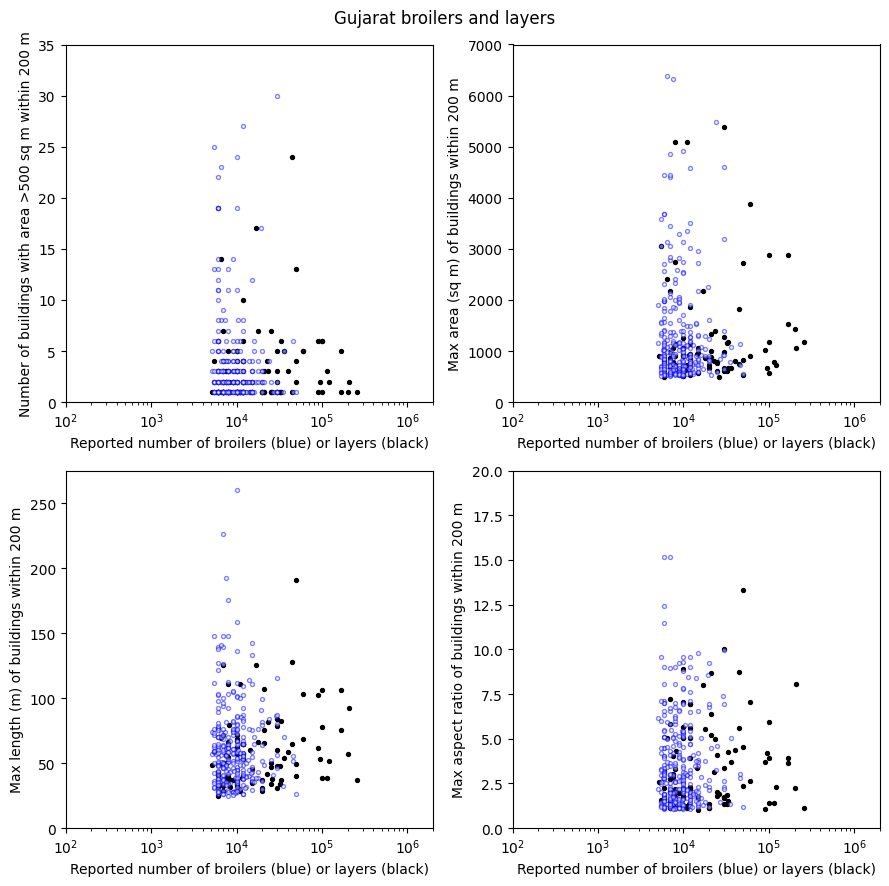

In [17]:
def building_scatterplots(broiler_df, layer_df, dist):

  def axis_stuff(ax):
    ax.set_xlim(1e2, 2e6)
    ax.set_xscale('log')
    ax.set_xlabel(f'Reported number of broilers (blue) or layers (black)')

  broiler_farms = broiler_df.groupby('index')
  layer_farms = layer_df.groupby('index')

  # Number of buildings vs quantity of animals
  for n, groups in enumerate([broiler_farms, layer_farms]):
    for group in groups:
      n_animals = group[1]['Stock'].unique()[0]
      #n_buildings = len(group[1])
      n_buildings = len(group[1][group[1]['area_in_meters'] > 500])
      if n == 0:
        # broilers
        ax1.scatter(n_animals, n_buildings, marker='o', s=8, facecolor='w',\
                    edgecolor='b', alpha=0.5, zorder=2)
      else:
        # layers
        ax1.scatter(n_animals, n_buildings, marker='o', s=8, color='k')
  axis_stuff(ax1)
  ax1.set_ylim(0, 35)
  ax1.set_ylabel(f'Number of buildings with area >500 sq m within {dist} m')

  # Max building size vs quantity of animalsdist
  for n, groups in enumerate([broiler_farms, layer_farms]):
    for group in groups:
      n_animals = group[1]['Stock'].unique()[0]
      med_area = group[1]['area_in_meters'].max()
      if n == 0:
        ax2.scatter(n_animals, med_area, marker='o', s=8, facecolor='w',\
                    edgecolor='b', alpha=0.5, zorder=2)
      else:
        ax2.scatter(n_animals, med_area, marker='o', s=8, color='k')
        # indicate the DMV poultry barn min and median areas
        #ax2.axhline(dmv_stats['AreaMeters'][0], ls=":", lw=1, color='gray')
        #ax2.axhline(dmv_stats['AreaMeters'][1], ls="--", lw=1, color='gray')
  axis_stuff(ax2)
  ax2.set_ylim(0, 7000)
  ax2.set_ylabel(f'Max area (sq m) of buildings within {dist} m')

  # Max building length vs quantity of animals
  for n, groups in enumerate([broiler_farms, layer_farms]):
    for group in groups:
      n_animals = group[1]['Stock'].unique()[0]
      med_length = group[1]['Length'].max()
      if n == 0:
        ax3.scatter(n_animals, med_length, marker='o', s=8, facecolor='w',\
                    edgecolor='b', alpha=0.5, zorder=2)
      else:
        ax3.scatter(n_animals, med_length, marker='o', s=8, color='k')
        # indicate the DMV poultry barn min and median lengths
        #ax3.axhline(dmv_stats['Length'][0], ls=":", lw=1, color='gray')
        #ax3.axhline(dmv_stats['Length'][1], ls="--", lw=1, color='gray')
  axis_stuff(ax3)
  ax3.set_ylim(0, 275)
  ax3.set_ylabel(f'Max length (m) of buildings within {dist} m')

  # Max building aspect ratio vs quantity of animals
  for n, groups in enumerate([broiler_farms, layer_farms]):
    for group in groups:
      n_animals = group[1]['Stock'].unique()[0]
      med_aspect = group[1]['Aspect Ratio'].max()
      if n == 0:
        ax4.scatter(n_animals, med_aspect, marker='o', s=8, facecolor='w',\
                    edgecolor='b', alpha=0.5, zorder=2)
      else:
        ax4.scatter(n_animals, med_aspect, marker='o', s=8, color='k')
        # indicate the DMV poultry barn min and median aspect ratios
        #ax4.axhline(dmv_stats['Aspect Ratio'][0], ls=":", lw=1, color='gray')
        #ax4.axhline(dmv_stats['Aspect Ratio'][1], ls="--", lw=1, color='gray')
  axis_stuff(ax4)
  ax4.set_ylim(0, 20)
  ax4.set_ylabel(f'Max aspect ratio of buildings within {dist} m')

  plt.suptitle('Gujarat broilers and layers')
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/CAFO_data/Analysis/Gujarat_farm_buildings.png')


_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))
building_scatterplots(broiler_bldgs_2, layer_bldgs_2, dist)

In [18]:
temp = broiler_bldgs_2[broiler_bldgs_2['Stock'] > 1e4]
groups = temp.groupby('index')
for n, group in enumerate(groups):
    length = group[1]['Aspect Ratio'].max()
    if length > 7.5:
      print(f"{length:.0f}")
      lon = [p.centroid.x for p in group[1]['geometry']]
      lat = [p.centroid.y for p in group[1]['geometry']]
      print(lat[0], lon[0])

10
22.537529881238797 73.07510197885371
10
22.535701165350176 72.92573519749249
8
22.528100602767324 72.92818310102004
8
23.45113978246457 72.76371971774284
9
23.016894702833714 73.06644870095201
10
22.845225893544722 72.71060154282164
8
22.602978902807735 70.88357230202149
9
22.52261410279467 70.98112060197393
9
20.538956829969838 72.9419039975723
